In [14]:
import numpy as np
import pandas as pd
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score ,precision_recall_curve

In [38]:
def parse_zip():
    path = Path('./dataset/titanic.zip')
    extract_to=Path('./dataset/titanic')
    if path.is_file():
        extract_to.mkdir(parents=True, exist_ok=True) 
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        path.unlink()    

In [20]:
parse_zip()

In [33]:
df = pd.read_csv('./dataset/titanic/train.csv').reset_index()

In [35]:
df.shape

(891, 13)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Survived     891 non-null    int64  
 3   Pclass       891 non-null    int64  
 4   Name         891 non-null    object 
 5   Sex          891 non-null    object 
 6   Age          714 non-null    float64
 7   SibSp        891 non-null    int64  
 8   Parch        891 non-null    int64  
 9   Ticket       891 non-null    object 
 10  Fare         891 non-null    float64
 11  Cabin        204 non-null    object 
 12  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


#### We have null values

In [37]:
df.describe()

,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,445.000000,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,445.000000,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.500000,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,890.000000,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


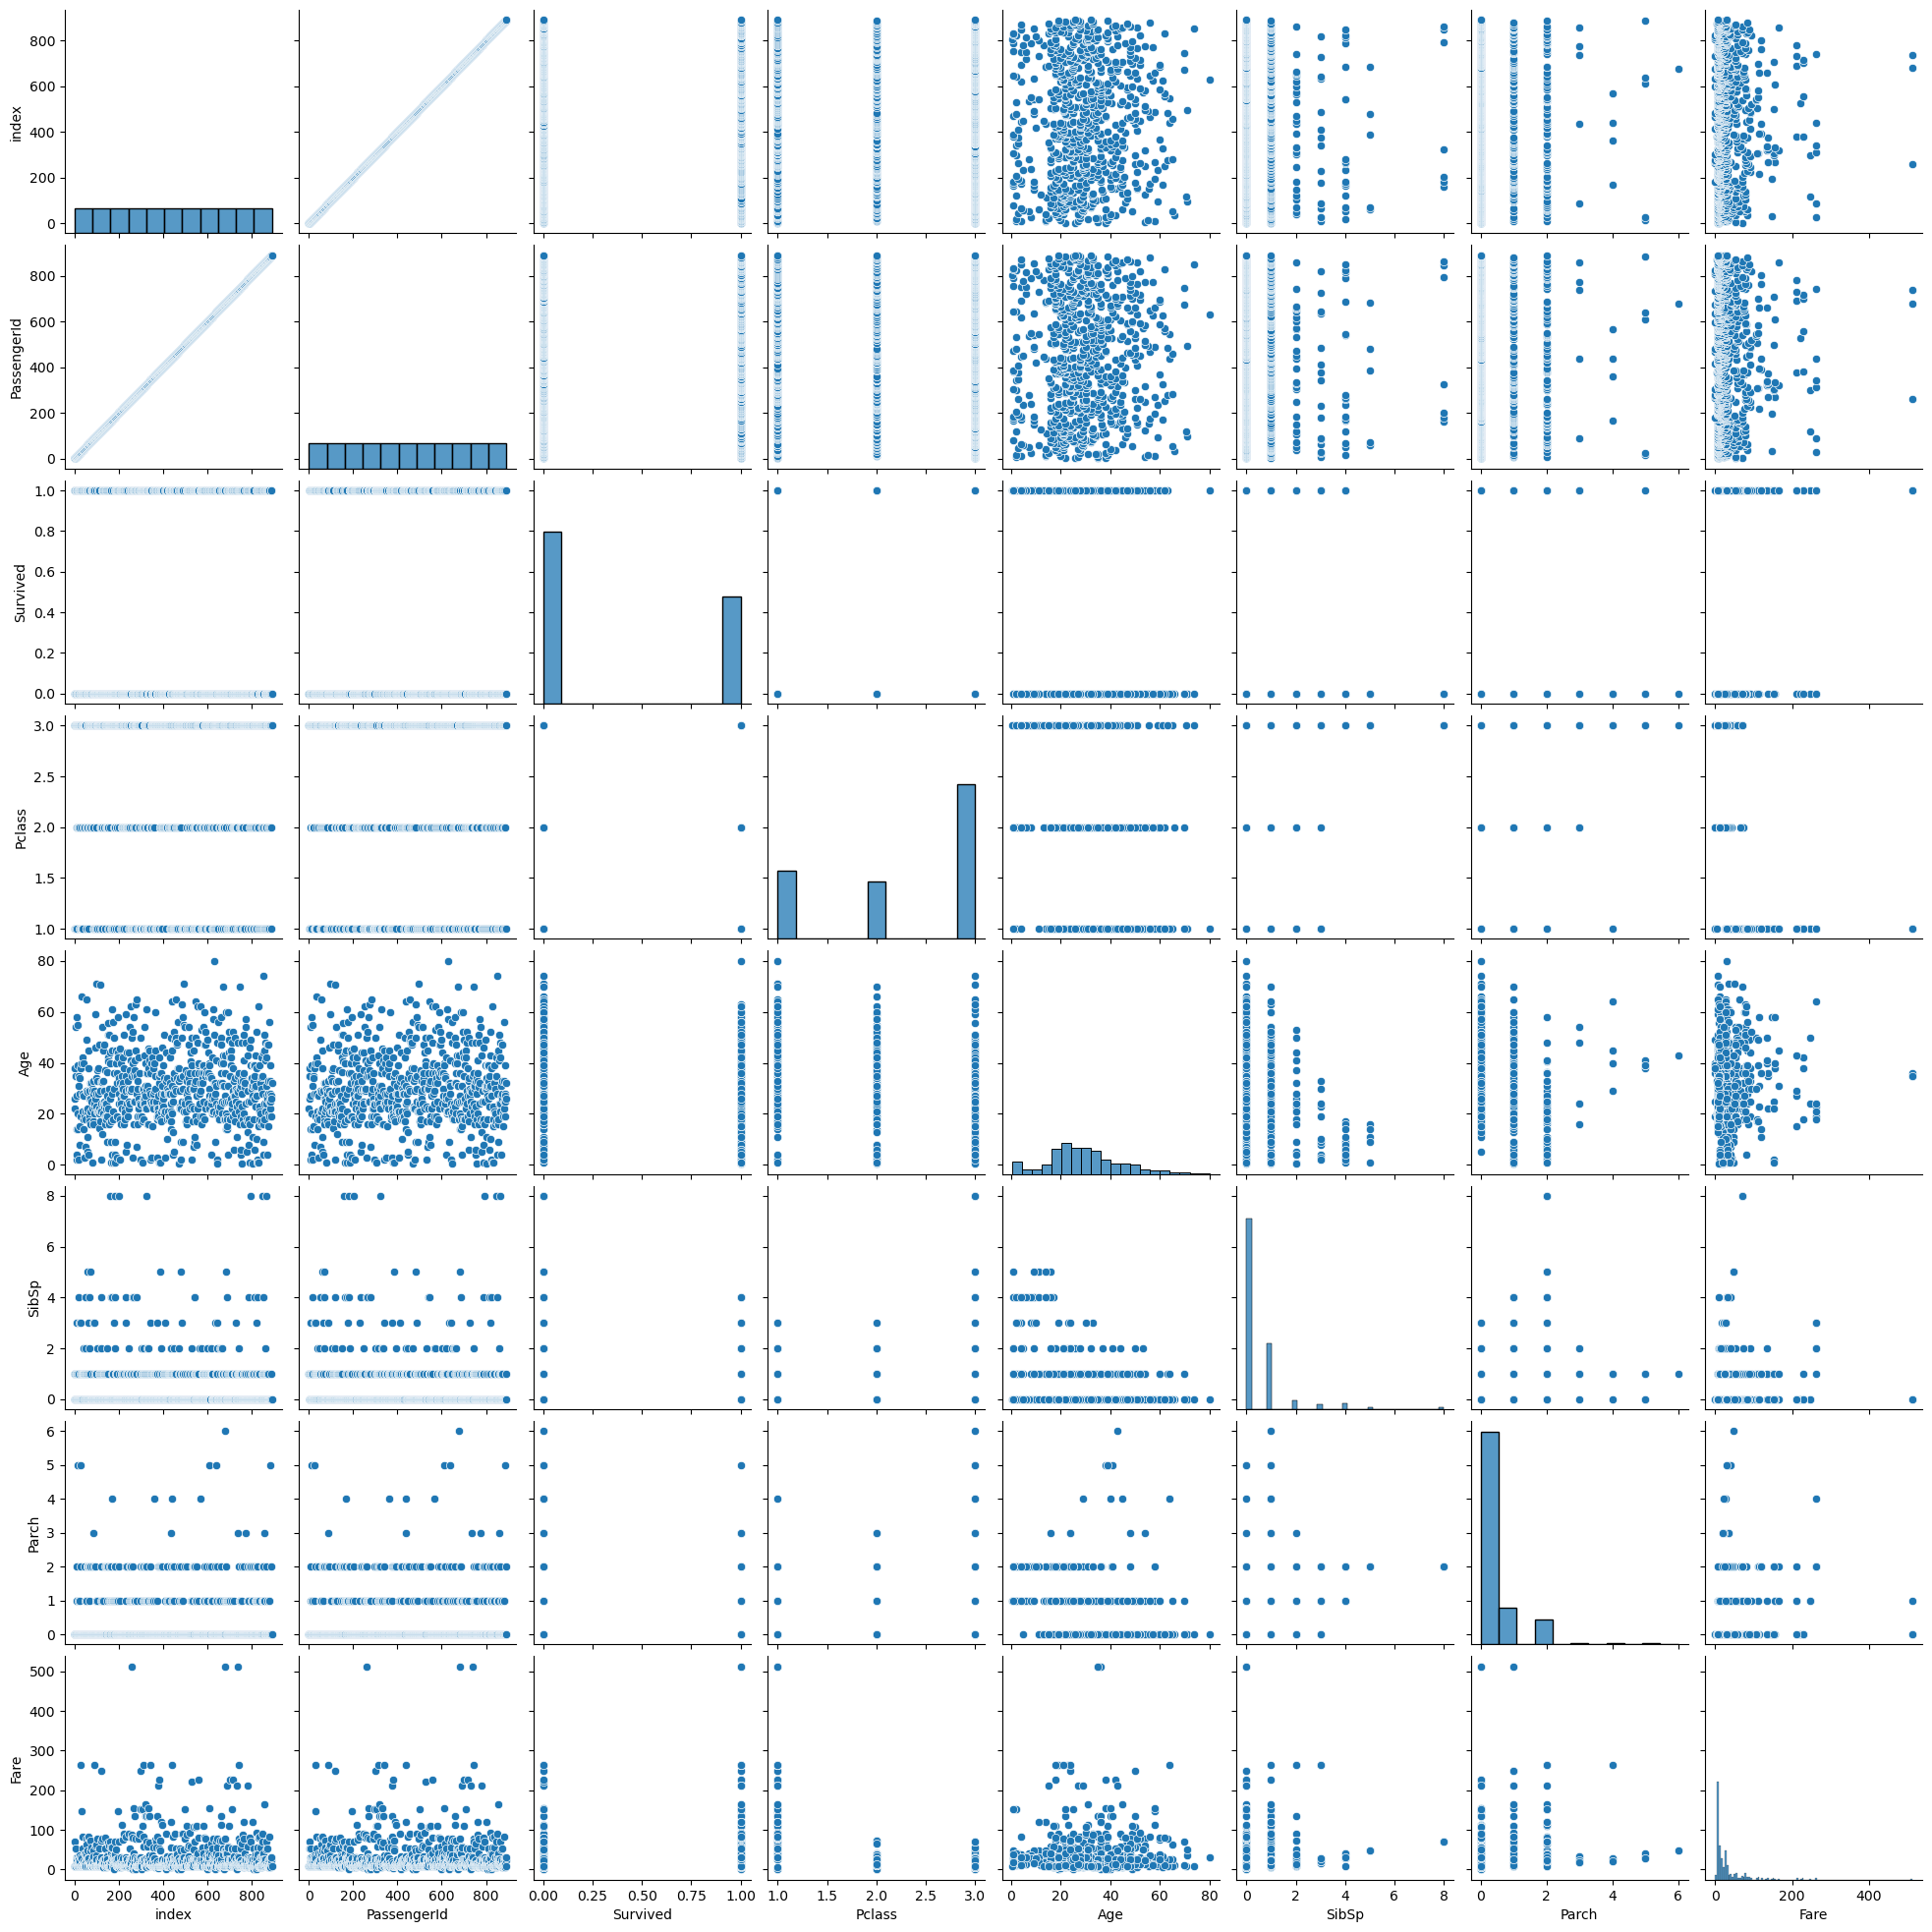

In [39]:
sns.pairplot(df)

I cant see any distinct pattern in the data

## let us look at the survival count to see data balance with the target

[Text(0, 0, '0'), Text(1, 0, '1')]

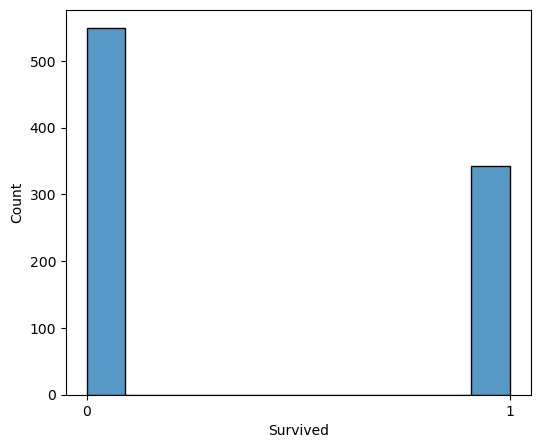

In [48]:
fig, ax = plt.subplots(figsize=(6,5))
sns.histplot(df, x='Survived', ax=ax)
ax.set_xticks([0,1])
ax.set_xticklabels([0,1])


#### There is call imbalance

## Let us look at outliers for few columns

In [52]:
df.columns

Index(['index', 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [53]:
box_cols = ['Age', 'Fare']

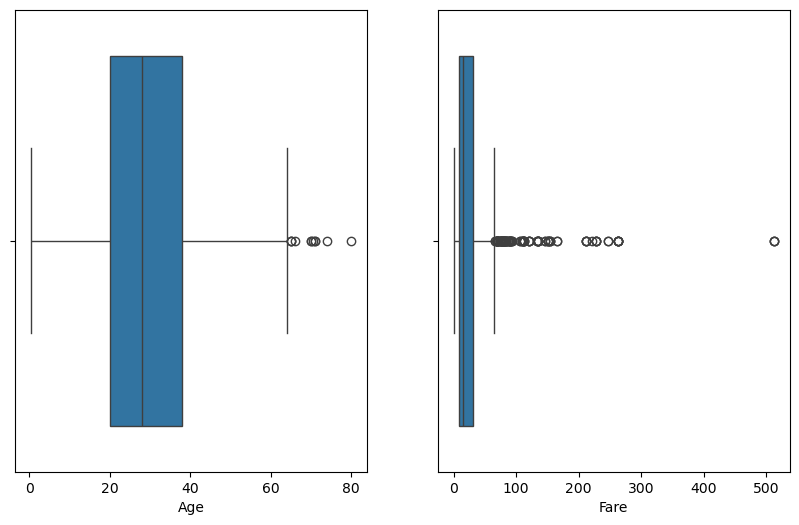

In [55]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
for eax, each in zip(ax, box_cols):
    sns.boxplot(df, x=each, ax=eax)

Outliers exists for fare and age

In [86]:
y = df['Survived'].to_numpy()

In [111]:
dfx = df.drop(columns=['Survived', 'index', 'Name', 'Ticket']) 

In [129]:
dfx.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,female,38.0,1,0,71.2833,C85,C
2,3,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,female,35.0,1,0,53.1000,C123,S
4,5,3,male,35.0,0,0,8.0500,NaN,S


## Let us run a preprocessing pipeline

In [113]:
numerical_col_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [114]:
categorical_col_pipeline= Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [115]:
preprocessing = ColumnTransformer([
    ('numerical_preprocess', numerical_col_pipeline, make_column_selector(dtype_include=np.number)),
    ('categorical_preprocess', categorical_col_pipeline, make_column_selector(dtype_exclude=np.number))
])

In [116]:
df_preprocessed = preprocessing.fit_transform(dfx)

In [117]:
df_preprocessed.shape


(891, 158)

In [118]:
df_preprocessed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8018 stored elements and shape (891, 158)>

In [120]:
dfpreprocessed = pd.DataFrame(df_preprocessed.toarray(), columns=preprocessing.get_feature_names_out())

In [127]:
X = dfpreprocessed.to_numpy()

In [130]:
## Make predicitons

## Logistic Regression

In [131]:
from sklearn.linear_model import LogisticRegression

In [132]:
lg_clf = LogisticRegression()

In [134]:
cross_val_score(lg_clf, X, y, cv=3 ,scoring="accuracy")

array([0.7979798 , 0.78451178, 0.79461279])

In [136]:
y_pred = cross_val_predict(lg_clf, X, y, cv=3, method="predict")

In [138]:
# accuracy
accuracy_score(y, y_pred)

0.792368125701459

In [139]:
precision_score(y, y_pred)

0.7430340557275542

In [140]:
recall_score(y, y_pred)

0.7017543859649122

In [141]:
f1_score(y, y_pred)

0.7218045112781954

## Let us look at the precision recall curve

In [145]:
y_score = cross_val_predict(lg_clf, X, y, cv=3, method="decision_function")

In [153]:
precisions, recalls, thresholds = precision_recall_curve(y, y_score)

In [152]:
# y_predict_proba =  cross_val_predict(lg_clf, X, y, cv=3, method="predict_proba")

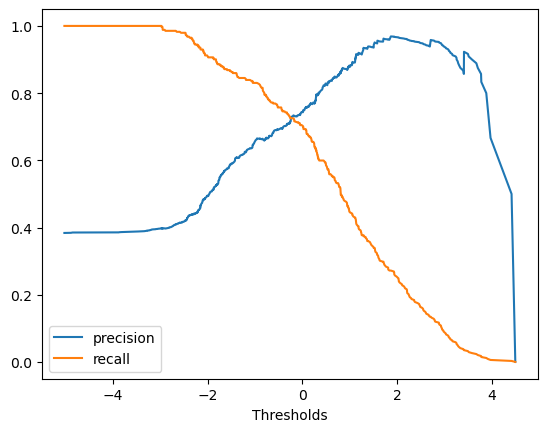

In [157]:
plt.plot(thresholds, precisions[:-1], label="precision")
plt.plot(thresholds, recalls[:-1], label='recall')
plt.xlabel('Thresholds')

plt.legend()

In [168]:
precisions[np.argmax(thresholds  > 2)]

0.9662921348314607

In [165]:
thresholds.shape

(891,)

## lets look at recall vs precision

Text(0, 0.5, 'precision')

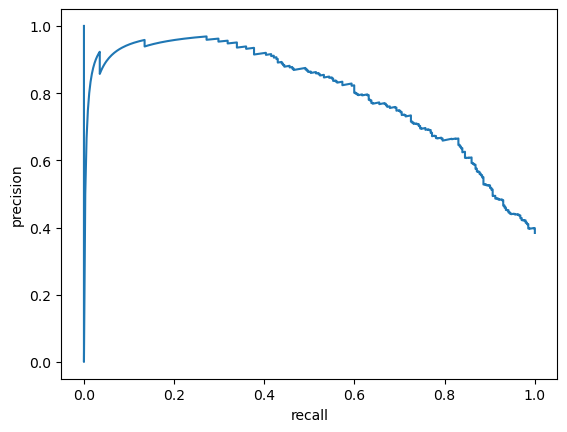

In [172]:
plt.plot(recalls, precisions)
plt.xlabel('recall')
plt.ylabel('precision')

In [184]:
## selecting threshold which gives precision of 95%
threshold_095 = thresholds[(precisions >= 0.95).argmax()]

In [185]:
# using the threshold to make a prediction
y_95 = y_score > threshold_095

In [182]:
precision_score(y, y_95)

0.9504132231404959

In [186]:
# since the precision is 95% recall has dropped to 33%
recall_score(y, y_95)

0.3362573099415205

We now have classifier with 95% precision. It is failrly easy to create a classifier with with any precision. But, a high precision classifier is not that useful if the recall is too low.

## Lets look at ROC(Receiver Operating Charactersitics) Curve

In [199]:
from sklearn.metrics import roc_curve, roc_auc_score

In [200]:
fpr, tpr, thresholds = roc_curve(y, y_score)

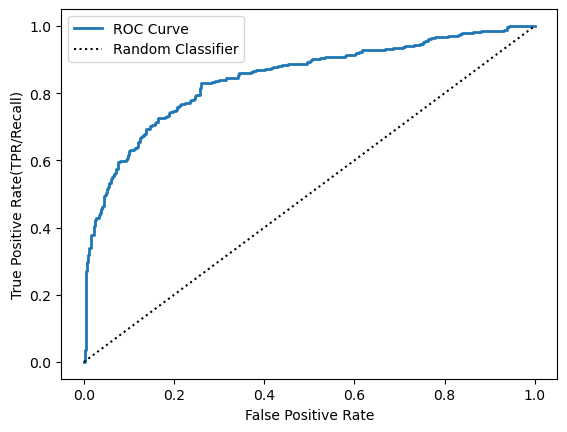

In [201]:
plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.plot(fpr, fpr,'k:' ,label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate(TPR/Recall)")

plt.legend()

## AUC Score

In [203]:
roc_auc_score(y, y_score)

0.8458494444977045

## Using Random Forest Classifier

In [204]:
from sklearn.ensemble import RandomForestClassifier

In [205]:
rf_clf = RandomForestClassifier()

In [207]:
cross_val_score(rf_clf, X,y, cv=3 ,scoring="accuracy" )

array([0.81144781, 0.80808081, 0.83501684])

In [208]:
y_pred = cross_val_predict(rf_clf, X, y, cv=3, method="predict")

In [213]:
y_score = cross_val_predict(rf_clf, X, y, cv=3, method="predict_proba")[:, 1]

In [215]:
accuracy_score(y, y_pred)

0.8204264870931538

In [216]:
precision_score(y, y_pred)

0.8159722222222222

In [217]:
recall_score(y, y_pred)

0.6871345029239766

In [218]:
precisions, recalls, thresholds = precision_recall_curve(y, y_score)

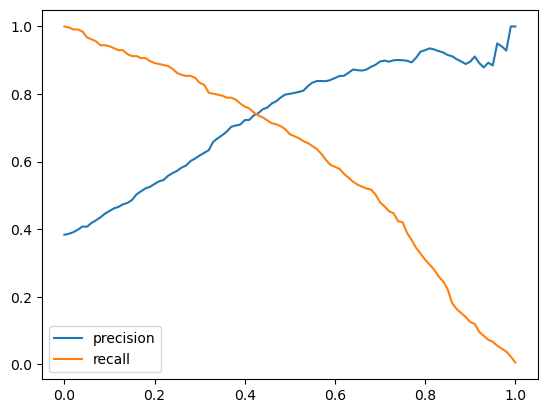

In [225]:
plt.plot(thresholds, precisions[:-1], label="precision")
plt.plot(thresholds, recalls[:-1], label="recall")

plt.legend()

### What is the current threshold?

The current precision score is:

In [229]:
curr_precision_score = precision_score(y, y_pred)

In [232]:
thresholds[(precisions >= curr_precision_score).argmax()]

0.54

Therefore, the current threshold is 0.54

Plotting the current threshold

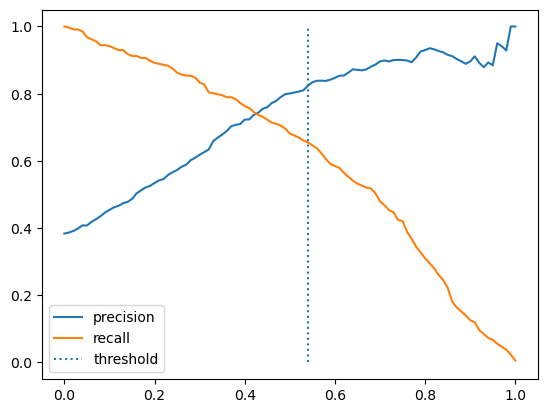

In [237]:
plt.plot(thresholds, precisions[:-1], label="precision")
plt.plot(thresholds, recalls[:-1], label="recall")
plt.vlines(0.54, ymin=0, ymax=1, linestyles='dotted', label="threshold")
plt.legend()

## roc curve

In [238]:
fpr, tpr, thresholds = roc_curve(y, y_score)

Text(0, 0.5, 'True Positive Rate(Recall)')

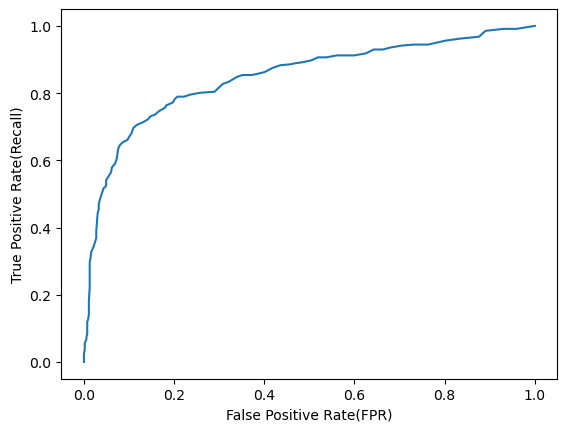

In [243]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(Recall)')

In [242]:
roc_auc_score(y, y_score)

0.8478546852863793